---
# 0️⃣ Data Load

In [1]:
import numpy as np
import pandas as pd

from pandas.api.types import is_string_dtype, is_numeric_dtype
from moda.dataprep import raw_to_ts, ts_to_range
import lasio
import math
import joypy
import scipy.stats as stats
from scipy.stats import zscore
from scipy.stats import mode

from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from dtaidistance import dtw
from dtaidistance import clustering

import time
from datetime import datetime, date, timedelta

import datetime as dt
import urllib
from urllib.error import URLError, HTTPError
import os
from dateutil import parser

import seaborn as sns
import matplotlib as mpl
import matplotlib.cbook as cbook
import matplotlib.colors as mcolors
import matplotlib.font_manager as fm
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as patches
import matplotlib.patheffects as path_effects
from matplotlib.patches import Rectangle
from matplotlib.patches import Polygon

from matplotlib import cm
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
from matplotlib.patches import Rectangle
from matplotlib.patches import Polygon

import koreanize_matplotlib
from highlight_text import fig_text, ax_text

import calmap
import calplot
import plotly.express as px
import plotly.graph_objects as go
import ipywidgets as widgets
import dataframe_image as dfi
from PIL import Image

## 경고메세지 숨기기
import warnings
warnings.filterwarnings(action='ignore')
## 숨겼던 경고메세지 다시 보이게하기
# warnings.filterwarnings(action='default')

## 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'Malgun Gothic'

%matplotlib inline
# pd.options.display.float_format='{:.2f}'.format

## -------------------------------------------------------------------------------- ## ->|
YJPATH = r"F:/YJ-RnDnote-WS/data/"
YJPATH3 = r'F:/YJ-format-230125/data/'
NCPATH = r"C:/app/Git-WS/2022/local-yjtest/23-YJ-RnDnote/YJH-RnDnote-WS/data/"
INDIR = r"001_pbp_raw/" 
OUTDIR = r"002_pbp_interim/"
OUTDIR3 = r'interim/'

kf = pd.read_csv('F:/YJ-RnDnote-WS/data/003_kbo_record_raw/KBO-record-c-0122.csv', encoding='utf-8')
color = pd.read_csv("F:/YJ-format-230125/data/team_colors3.csv", encoding='cp949')

raw = pd.read_csv(YJPATH + OUTDIR + r'pbp-zone-2023-02-20-2.csv', encoding='cp949', low_memory=False)
raw["game_date"] = pd.to_datetime(raw.game_date, format='%Y-%m-%d')

def two_digit(n): 
    return f"{n:02d}"
raw['bs_cnt']=raw['bs_cnt'].apply(two_digit)

def six_digit(n): 
    return f"{n:06d}"
raw['bso_rcnt']=raw['bso_rcnt'].apply(six_digit)

raw.drop_duplicates(inplace=True)
raw.shape

(1308468, 184)

---
# 1️⃣ Data get Interval

In [2]:
d = datetime.today().date()
pf = pd.read_csv(r'F:/YJ-format-230125/data/interim/pbp-zone-2023-02-21.csv', encoding="cp949", low_memory=False)

pf.drop_duplicates(inplace=True)
pf.shape # 1차 (2030182, 71)

def calculate_dt(dt):
    game_dt = datetime.strptime(dt, "%Y-%m-%d") # game_dt = datetime.strptime(dt, "%Y%m%d").date()
    return game_dt
pf["game_date"] = pf["game_date"].apply(calculate_dt)

## FA 전팀
CATCHER = ['권정웅-65412', '박세혁-62244', '안중열-64022', '박동원-79365', '허도환-77243', '양의지-76232', '유강남-61102', '이재용-67993', '주효상-66354']
TEAM = ['SS', 'DS', 'LG', 'KIA', 'HH', 'NC', 'LG', 'NC', 'WO']
for c, t in zip(CATCHER, TEAM):
    pf['p_team'] = np.where((pf['yy']==2022) & (pf['cid']=='{}'.format(c)), '{}'.format(t), pf['p_team'])
    pf['a_team'] = np.where((pf['yy']==2022) & (pf['cid']=='{}'.format(c)), '{}'.format(t), pf['a_team'])
    pf['h_team'] = np.where((pf['yy']==2022) & (pf['cid']=='{}'.format(c)), '{}'.format(t), pf['h_team'])

### 1) pitch_Array

In [3]:
d = datetime.today().date()
ydpt = pd.read_csv('F:/YJ-format-230125/data/interim/pbp-arr-first-last-2023-02-22-2.csv', encoding="cp949", low_memory=False)
ydpt.drop_duplicates(inplace=True)
ydpt.shape # 1차 (2030182, 71)

def calculate_dt(dt):
    game_dt = datetime.strptime(dt, "%Y-%m-%d") # game_dt = datetime.strptime(dt, "%Y%m%d").date()
    return game_dt
ydpt["game_date"] = ydpt["game_date"].apply(calculate_dt)

## FA 전팀
CATCHER = ['권정웅-65412', '박세혁-62244', '안중열-64022', '박동원-79365', '허도환-77243', '양의지-76232', '유강남-61102', '이재용-67993', '주효상-66354']
TEAM = ['SS', 'DS', 'LG', 'KIA', 'HH', 'NC', 'LG', 'NC', 'WO']
for c, t in zip(CATCHER, TEAM):
    ydpt['p_team'] = np.where((ydpt['yy']==2022) & (ydpt['cid']=='{}'.format(c)), '{}'.format(t), ydpt['p_team'])
    ydpt['a_team'] = np.where((ydpt['yy']==2022) & (ydpt['cid']=='{}'.format(c)), '{}'.format(t), ydpt['a_team'])
    ydpt['h_team'] = np.where((ydpt['yy']==2022) & (ydpt['cid']=='{}'.format(c)), '{}'.format(t), ydpt['h_team'])
    
## seq5
ydpt['pit_seq5'] = ydpt['pit_first1'] + "|" + ydpt['pit_last4'] + "|" + ydpt['pit_last3'] + "|" + ydpt['pit_last2'] + "|" + ydpt['pit_last1']
ydpt['pit_cls4'] = ydpt['pit_cls_first1'] + "|" + ydpt['pit_cls_last4'] + "|" + ydpt['pit_cls_last3'] + "|" + ydpt['pit_cls_last2'] + "|" + ydpt['pit_cls_last1']
ydpt['z101_seq5'] = ydpt['z101_first1'].astype(str) + "|" + ydpt['z101_last4'].astype(str) + "|" + ydpt['z101_last3'].astype(str) + "|" + ydpt['z101_last2'].astype(str) + "|" + ydpt['z101_last1'].astype(str)
ydpt['z101sh_seq5'] = ydpt['z101sh_first1'] + "|" + ydpt['z101sh_last4'] + "|" + ydpt['z101sh_last3'] + "|" + ydpt['z101sh_last2'] + "|" + ydpt['z101sh_last1']
ydpt['z101th_seq5'] = ydpt['z101th_first1'] + "|" + ydpt['z101th_last4'] + "|" + ydpt['z101th_last3'] + "|" + ydpt['z101th_last2'] + "|" + ydpt['z101th_last1']
ydpt['pit_z101th_seq5'] = ydpt['pit_z101th_first1'] + "|" + ydpt['pit_z101th_last4'] + "|" + ydpt['pit_z101th_last3'] + "|" + ydpt['pit_z101th_last2'] + "|" + ydpt['pit_z101th_last1']
ydpt['pit_z101_seq5'] = ydpt['pit_z101_first1'] + "|" + ydpt['pit_z101_last4'] + "|" + ydpt['pit_z101_last3'] + "|" + ydpt['pit_z101_last2'] + "|" + ydpt['pit_z101_last1']
ydpt['pit_z101sh_seq5'] = ydpt['pit_z101sh_first1'] + "|" + ydpt['pit_z101sh_last4'] + "|" + ydpt['pit_z101sh_last3'] + "|" + ydpt['pit_z101sh_last2'] + "|" + ydpt['pit_z101sh_last1']
## seq4
ydpt['pit_seq4'] = ydpt['pit_first1'] + "|" + ydpt['pit_last3'] + "|" + ydpt['pit_last2'] + "|" + ydpt['pit_last1']
ydpt['pit_cls4'] = ydpt['pit_cls_first1'] + "|" + ydpt['pit_cls_last3'] + "|" + ydpt['pit_cls_last2'] + "|" + ydpt['pit_cls_last1']
ydpt['z101_seq4'] = ydpt['z101_first1'].astype(str)+ "|" + ydpt['z101_last3'].astype(str) + "|" + ydpt['z101_last2'].astype(str) + "|" + ydpt['z101_last1'].astype(str)
ydpt['pit_z101_seq4'] = ydpt['pit_z101_first1'] + "|" + ydpt['pit_z101_last3'] + "|" + ydpt['pit_z101_last2'] + "|" + ydpt['pit_z101_last1']
ydpt['z101sh_seq4'] = ydpt['z101sh_first1'] + "|" + ydpt['z101sh_last3'] + "|" + ydpt['z101sh_last2'] + "|" + ydpt['z101sh_last1']
ydpt['z101th_seq4'] = ydpt['z101th_first1'] + "|" + ydpt['z101th_last3'] + "|" + ydpt['z101th_last2'] + "|" + ydpt['z101th_last1']
ydpt['pit_z101th_seq4'] = ydpt['pit_z101th_first1'] + "|" + ydpt['pit_z101th_last3'] + "|" + ydpt['pit_z101th_last2'] + "|" + ydpt['pit_z101th_last1']
ydpt['pit_z101sh_seq4'] = ydpt['pit_z101sh_first1'] + "|" + ydpt['pit_z101sh_last3'] + "|" + ydpt['pit_z101sh_last2'] + "|" + ydpt['pit_z101sh_last1']

ydpt['throws_stands'] = ydpt['throws'] +'_'+ ydpt['stands']

### 2) game_date × cid × pit_seq4 per pa

In [4]:
gid = pf.query("yy==2022").groupby(['cid']).agg(gid_cnt=('gid','nunique')).reset_index().sort_values('gid_cnt',ascending=False)
labels = [7, 6, 5, 4, 3, 2, 1, 0]; bins = [0, 6, 30, 50, 80, 100, 120, 140]
gid_bins = pd.cut(gid['gid_cnt'] ,bins, labels=labels[:-1])

## merge
gid['score'] = gid_bins
df22=pd.merge(pf, gid, on='cid', how='left')

score = df22.groupby(['catcher']).agg(score = ('score', 'unique')).reset_index()
score['score'] = score['score'].str[0]
score = score.sort_values('score', ascending=True)

In [5]:
ydpt4_cid = ydpt.query("pit_len >=4").groupby(['yy', 'ym', 'game_date', 'gid', 'cid', 'p_team', 'pit_seq4']).agg(pa=('gid-intot-panum', 'count')).reset_index().sort_values(by=['cid', 'pa'], ascending=(True, False))

## 
gid = pf.query("yy==2022").groupby(['yy', 'cid']).agg(gid_cnt=('gid','nunique')).reset_index().sort_values('gid_cnt',ascending=False)
labels = [7, 6, 5, 4, 3, 2, 1, 0]; bins = [0, 6, 30, 50, 80, 100, 120, 140]
gid_bins = pd.cut(gid['gid_cnt'] ,bins, labels=labels[:-1])

## date convert
def calculate_dt(dt):
    game_dt = datetime.strptime(dt, "%Y-%m-%d")
    return game_dt

## merge
gid['score'] = gid_bins
gid = gid[['cid', 'score']]
ydpt4_cid2 = pd.merge(ydpt4_cid, gid, on='cid', how='left')
ydpt4_cid22 = ydpt4_cid2.query("yy=='2022-01-01'")
# ydpt4_cid22.describe(percentiles=(.1, .2, .25, .3, .4, .5, .6, .7, .75, .8, .9, .95, .99, .995, .9975, .999)) #13

In [6]:
cid = ydpt4_cid22.groupby(['cid']).agg(ptseq=('pit_seq4','count')).reset_index().sort_values('ptseq', ascending=False)

---
# 2️⃣ Stanine
<img src="https://mblogthumb-phinf.pstatic.net/data25/2008/10/10/197/800px-normal_distribution_and_scales_keatom01.gif?type=w420">

In [7]:
# 타석 2개 이상의 패턴 집계
cid = ydpt4_cid.query("pa>=2").groupby(['cid']).agg(pt_cnt=('pit_seq4','count')).reset_index().sort_values('pt_cnt', ascending=False)
cid.describe(percentiles=(.04, .11, .23, .40, .60, .77, .89, .96, 1.0))

,pt_cnt
count,89.000000
mean,843.696629
std,1400.855448
min,1.000000
4%,1.000000
11%,3.000000
23%,21.000000
40%,77.200000
50%,167.000000
60%,395.600000


In [175]:
ydpt4_cid = ydpt.query("pit_len >=4").groupby(['yy', 'ym', 'game_date', 'gid', 'cid', 'p_team', 'pit_seq4']).agg(pa=('gid-intot-panum', 'count')).reset_index().sort_values(by=['cid', 'pa'], ascending=(True, False))
ydpt4_cid.head(1)

,yy,ym,game_date,gid,cid,p_team,pit_seq4,pa
32628,2019-01-01,2019-03-01,2019-03-24,20190324-SS-NC-창원,강민호-74540,SS,직구|직구|직구|직구,10


In [ ]:
ydpt4_cid22 = ydpt4_cid.query("pa>=2").groupby(['yy', 'cid']).agg(pt_cnt=('pit_seq4','nunique'), pa =('pa','sum'), gid =('gid','nunique')).reset_index().sort_values('pt_cnt', ascending=False)
df22=pd.merge(pf, gid, on='cid', how='left')

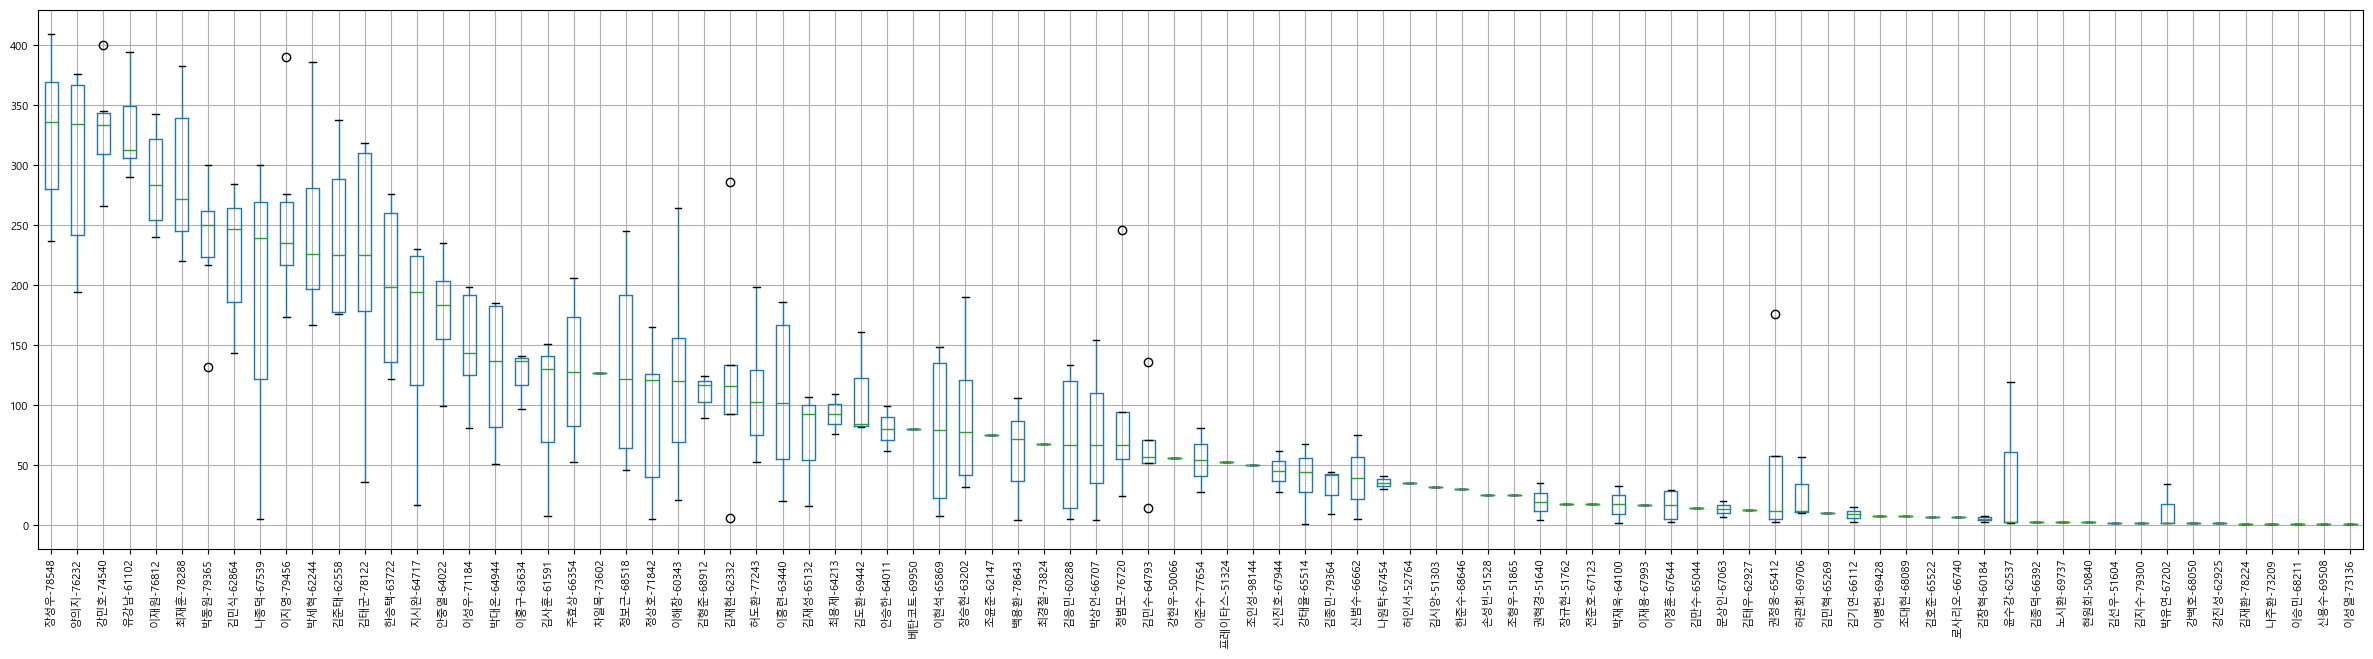

In [15]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

def boxplot_sorted(ydpt4_cid22, by, column, rot=0):
    ydpt4_cid22 = pd.DataFrame({col:vals[column] for col, vals in ydpt4_cid22.groupby(by)})
    meds = ydpt4_cid22.median().sort_values(ascending=False)
    return ydpt4_cid22[meds.index].boxplot(rot=rot, return_type="axes")

plt.figure(figsize=(30,7))
ydpt4_cid22.sort_values(by=['cid', 'pt_cnt'], ascending=(False, False))
axes = boxplot_sorted(ydpt4_cid22, by = ['cid'], column ='pt_cnt')
plt.xticks(rotation=90)
plt.rc('font', size=8)
plt.show()

### 3) 년별 고유 패턴수|타석수|게임수 집계의 zscore 계산

In [196]:
pf22 = ydpt4_cid.query("yy=='2022-01-01' and pa>=2").groupby(['cid']).agg( pitseq = ('pit_seq4', 'nunique'), pa = ('pa', 'sum'), gid = ('gid', 'nunique')).reset_index().sort_values(by=['pitseq', 'pa'], ascending=(False, False))
pf22['yy'] = '2022'
pf22 =pf22.reset_index(drop=True)
pf22["IDX"] = pf22.index +1

pf22 = pf22[['yy', 'IDX', 'cid', 'pitseq', 'pa', 'gid']]

## -------------------------------------------------- ##
## -------------------------------------------------- ##
ZMEAN = pf22["pitseq"].max().round(0); 
ZSTD = pf22["pitseq"].std().round(0);

## 1. z-score
pf22["pitseq_zscore"] = stats.zscore(pf22["pitseq"])
pf22["pitseq_zscore"] = (pf22["pitseq_zscore"] * ZSTD) + ZMEAN
pf22["pitseq_zscore"] = pf22["pitseq_zscore"].round(0)

pf22["pitseq_zscore"] = pf22["pitseq_zscore"].astype(int)

pf22_a = pf22.groupby(["yy", "pitseq", "pitseq_zscore"])[["pitseq_zscore"]].agg(zcnt=("pitseq_zscore", "count")).sort_values(["yy", "pitseq", "pitseq_zscore"], ascending=False).reset_index()
pf22_a = pf22_a.groupby(["yy", "pitseq", "pitseq_zscore", "zcnt"])[["zcnt"]].sum().groupby(level=0).agg(zcumsum=("zcnt", "cumsum")).sort_values(["yy", "pitseq", "pitseq_zscore"], ascending=False).reset_index()
pf22_a["zcumsum_new"] = pf22_a.groupby("yy")["zcumsum"].shift(-1).fillna(0).astype(int)

pf22_b = pf22_a.groupby(["yy"])[["zcnt"]].agg(total=("zcnt", "sum")).sort_values(["yy"], ascending=False).reset_index()
pf22_c = pd.merge(pf22_a, pf22_b, how="left", on="yy")
## -------------------------------------------------- ##
## 2.2 cumsum
lower = pf22_c["zcumsum_new"]
equal = pf22_c["zcnt"]
total = pf22_c["total"]
pf22_c["percentile"] = ((lower + (equal/2)) / total) *100
pf22_c["percentile"] = pf22_c["percentile"].round(1)

## -------------------------------------------------- ##
## 3. G_stanine
ranges = [0, 4, 11, 23, 40, 60, 77, 89, 96, 100]
labels = ["9", "8", "7", "6", "5", "4", "3", "2", "1"]
pf22_c["pitseq_stanine"] = pd.cut(pf22_c["percentile"], bins=ranges, labels=labels)

## -------------------------------------------------- ##
## 4. merge
pf22_d = pf22.sort_values(["yy", "pitseq", "pitseq_zscore"], ascending=False)
pf22 = pd.merge(pf22_d, pf22_c, how="left", on=["yy", "pitseq", "pitseq_zscore"])
pf22.drop(columns=["zcnt", "zcumsum", "zcumsum_new", "total", "percentile"], inplace=True)
pf22 = pf22.sort_values(["IDX"], ascending=True)

## -------------------------------------------------- ##
## -------------------------------------------------- ##
ZMEAN = pf22["pa"].max().round(0); 
ZSTD = pf22["pa"].std().round(0);

## 1. z-score
pf22["pa_zscore"] = stats.zscore(pf22["pa"])
pf22["pa_zscore"] = (pf22["pa_zscore"] * ZSTD) + ZMEAN
pf22["pa_zscore"] = pf22["pa_zscore"].round(0)

pf22["pa_zscore"] = pf22["pa_zscore"].astype(int)

pf22_a = pf22.groupby(["yy", "pa", "pa_zscore"])[["pa_zscore"]].agg(zcnt=("pa_zscore", "count")).sort_values(["yy", "pa", "pa_zscore"], ascending=False).reset_index()
pf22_a = pf22_a.groupby(["yy", "pa", "pa_zscore", "zcnt"])[["zcnt"]].sum().groupby(level=0).agg(zcumsum=("zcnt", "cumsum")).sort_values(["yy", "pa", "pa_zscore"], ascending=False).reset_index()
pf22_a["zcumsum_new"] = pf22_a.groupby("yy")["zcumsum"].shift(-1).fillna(0).astype(int)

pf22_b = pf22_a.groupby(["yy"])[["zcnt"]].agg(total=("zcnt", "sum")).sort_values(["yy"], ascending=False).reset_index()
pf22_c = pd.merge(pf22_a, pf22_b, how="left", on="yy")
## -------------------------------------------------- ##
## 2.2 cumsum
lower = pf22_c["zcumsum_new"]
equal = pf22_c["zcnt"]
total = pf22_c["total"]
pf22_c["percentile"] = ((lower + (equal/2)) / total) *100
pf22_c["percentile"] = pf22_c["percentile"].round(1)

## -------------------------------------------------- ##
## 3. G_stanine
ranges = [0, 4, 11, 23, 40, 60, 77, 89, 96, 100]
labels = ["9", "8", "7", "6", "5", "4", "3", "2", "1"]
pf22_c["pa_stanine"] = pd.cut(pf22_c["percentile"], bins=ranges, labels=labels)

## -------------------------------------------------- ##
## 4. merge
pf22_d = pf22.sort_values(["yy", "pa", "pa_zscore"], ascending=False)
pf22 = pd.merge(pf22_d, pf22_c, how="left", on=["yy", "pa", "pa_zscore"])
pf22.drop(columns=["zcnt", "zcumsum", "zcumsum_new", "total", "percentile"], inplace=True)
pf22 = pf22.sort_values(["IDX"], ascending=True)

## -------------------------------------------------- ##
## -------------------------------------------------- ##
ZMEAN = pf22["gid"].max().round(0); 
ZSTD = pf22["gid"].std().round(0);

## 1. z-score
pf22["gid_zscore"] = stats.zscore(pf22["gid"])
pf22["gid_zscore"] = (pf22["gid_zscore"] * ZSTD) + ZMEAN
pf22["gid_zscore"] = pf22["gid_zscore"].round(0)

pf22["gid_zscore"] = pf22["gid_zscore"].astype(int)

pf22_a = pf22.groupby(["yy", "gid", "gid_zscore"])[["gid_zscore"]].agg(zcnt=("gid_zscore", "count")).sort_values(["yy", "gid", "gid_zscore"], ascending=False).reset_index()
pf22_a = pf22_a.groupby(["yy", "gid", "gid_zscore", "zcnt"])[["zcnt"]].sum().groupby(level=0).agg(zcumsum=("zcnt", "cumsum")).sort_values(["yy", "gid", "gid_zscore"], ascending=False).reset_index()
pf22_a["zcumsum_new"] = pf22_a.groupby("yy")["zcumsum"].shift(-1).fillna(0).astype(int)

pf22_b = pf22_a.groupby(["yy"])[["zcnt"]].agg(total=("zcnt", "sum")).sort_values(["yy"], ascending=False).reset_index()
pf22_c = pd.merge(pf22_a, pf22_b, how="left", on="yy")
## -------------------------------------------------- ##
## 2.2 cumsum
lower = pf22_c["zcumsum_new"]
equal = pf22_c["zcnt"]
total = pf22_c["total"]
pf22_c["percentile"] = ((lower + (equal/2)) / total) *100
pf22_c["percentile"] = pf22_c["percentile"].round(1)

## -------------------------------------------------- ##
## 3. G_stanine
ranges = [0, 4, 11, 23, 40, 60, 77, 89, 96, 100]
labels = ["9", "8", "7", "6", "5", "4", "3", "2", "1"]
pf22_c["gid_stanine"] = pd.cut(pf22_c["percentile"], bins=ranges, labels=labels)

## -------------------------------------------------- ##
## 4. merge
pf22_d = pf22.sort_values(["yy", "gid", "gid_zscore"], ascending=False)
pf22 = pd.merge(pf22_d, pf22_c, how="left", on=["yy", "gid", "gid_zscore"])
pf22.drop(columns=["zcnt", "zcumsum", "zcumsum_new", "total", "percentile"], inplace=True)
pf22 = pf22.sort_values(["IDX"], ascending=True)

## -------------------------------------------------- ##
## -------------------------------------------------- ##
ZMEAN = pf22["pitseq"].max().round(0); 
ZSTD = pf22["pitseq"].std().round(0);

## 1. z-score
pf22_a = pf22.groupby(["yy", "pitseq", "pitseq_zscore"])[["pitseq_zscore"]].agg(zcnt=("pitseq_zscore", "count")).sort_values(["yy", "pitseq", "pitseq_zscore"], ascending=False).reset_index()
pf22_a = pf22_a.groupby(["yy", "pitseq", "pitseq_zscore", "zcnt"])[["zcnt"]].sum().groupby(level=0).agg(zcumsum=("zcnt", "cumsum")).sort_values(["yy", "pitseq", "pitseq_zscore"], ascending=False).reset_index()
pf22_a["zcumsum_new"] = pf22_a.groupby("yy")["zcumsum"].shift(-1).fillna(0).astype(int)

pf22_b = pf22_a.groupby(["yy"])[["zcnt"]].agg(total=("zcnt", "sum")).sort_values(["yy"], ascending=False).reset_index()
pf22_c = pd.merge(pf22_a, pf22_b, how="left", on="yy")
## -------------------------------------------------- ##
## 2.2 cumsum
lower = pf22_c["zcumsum_new"]
equal = pf22_c["zcnt"]
total = pf22_c["total"]
pf22_c["percentile"] = ((lower + (equal/2)) / total) *100
pf22_c["percentile"] = pf22_c["percentile"].round(1)

## -------------------------------------------------- ##
## 3. G_stanine

ranges = [0, 11, 27, 40, 60, 77, 100] # (89, 7,6,5,4, 123)
labels = ["6", "5", "4", "3", "2", "1"]
pf22_c["pitseq_stanine2"] = pd.cut(pf22_c["percentile"], bins=ranges, labels=labels)

## -------------------------------------------------- ##
## 4. merge
pf22_d = pf22.sort_values(["yy", "pitseq", "pitseq_zscore"], ascending=False)
pf22 = pd.merge(pf22_d, pf22_c, how="left", on=["yy", "pitseq", "pitseq_zscore"])
pf22.drop(columns=["zcnt", "zcumsum", "zcumsum_new", "total", "percentile"], inplace=True)
pf22 = pf22.sort_values(["IDX"], ascending=True)
pf22.head(5)

,yy,IDX,cid,pitseq,pa,gid,pitseq_zscore,pitseq_stanine,pa_zscore,pa_stanine,gid_zscore,gid_stanine,pitseq_stanine2
0,2022,1,이지영-79456,390,2208,136,656,1,3964,1,229,1,1
1,2022,2,양의지-76232,367,1701,94,632,1,3451,3,187,3,1
2,2022,3,강민호-74540,338,1628,90,603,2,3377,3,183,3,1
3,2022,4,유강남-61102,309,2395,131,574,2,4153,1,224,1,1
4,2022,5,박동원-79365,300,1923,110,564,2,3676,2,203,2,1


In [198]:
# 1패턴으로 처리한 타석수
pf22['pa_pitseq'] = round(pf22['pa_zscore']/pf22['pitseq_zscore'],2)
# 1게임당 사용 패턴수
pf22['pitseq_gid'] = round(pf22['pitseq_zscore']/pf22['gid_zscore'],2)

ZMEAN = pf22["pa_pitseq"].max().round(0); 
ZSTD = pf22["pa_pitseq"].std().round(0);

## 1. z-score
pf22["pa_pitseq_zscore"] = stats.zscore(pf22["pa_pitseq"])
pf22["pa_pitseq_zscore"] = (pf22["pa_pitseq_zscore"] * ZSTD) + ZMEAN
pf22["pa_pitseq_zscore"] = pf22["pa_pitseq_zscore"].round(0)

pf22["pa_pitseq_zscore"] = pf22["pa_pitseq_zscore"].astype(int)

pf22_a = pf22.groupby(["yy", "pa_pitseq", "pa_pitseq_zscore"])[["pa_pitseq_zscore"]].agg(zcnt=("pa_pitseq_zscore", "count")).sort_values(["yy", "pa_pitseq", "pa_pitseq_zscore"], ascending=False).reset_index()
pf22_a = pf22_a.groupby(["yy", "pa_pitseq", "pa_pitseq_zscore", "zcnt"])[["zcnt"]].sum().groupby(level=0).agg(zcumsum=("zcnt", "cumsum")).sort_values(["yy", "pa_pitseq", "pa_pitseq_zscore"], ascending=False).reset_index()
pf22_a["zcumsum_new"] = pf22_a.groupby("yy")["zcumsum"].shift(-1).fillna(0).astype(int)

pf22_b = pf22_a.groupby(["yy"])[["zcnt"]].agg(total=("zcnt", "sum")).sort_values(["yy"], ascending=False).reset_index()
pf22_c = pd.merge(pf22_a, pf22_b, how="left", on="yy")
## -------------------------------------------------- ##
## 2.2 cumsum
lower = pf22_c["zcumsum_new"]
equal = pf22_c["zcnt"]
total = pf22_c["total"]
pf22_c["percentile"] = ((lower + (equal/2)) / total) *100
pf22_c["percentile"] = pf22_c["percentile"].round(1)

## -------------------------------------------------- ##
## 3. G_stanine
ranges = [0, 4, 11, 23, 40, 60, 77, 89, 96, 100]
labels = ["9", "8", "7", "6", "5", "4", "3", "2", "1"]
pf22_c["pa_pitseq_stanine"] = pd.cut(pf22_c["percentile"], bins=ranges, labels=labels)

## -------------------------------------------------- ##
## 4. merge
pf22_d = pf22.sort_values(["yy", "pa_pitseq", "pa_pitseq_zscore"], ascending=False)
pf22 = pd.merge(pf22_d, pf22_c, how="left", on=["yy", "pa_pitseq", "pa_pitseq_zscore"])
pf22.drop(columns=["zcnt", "zcumsum", "zcumsum_new", "total", "percentile"], inplace=True)
pf22 = pf22.sort_values(["IDX"], ascending=True)
pf22.head(10)

,yy,IDX,cid,pitseq,pa,gid,pitseq_zscore,pitseq_stanine,pa_zscore,pa_stanine,gid_zscore,gid_stanine,pitseq_stanine2,pa_pitseq,pitseq_gid,pa_pitseq_zscore,pa_pitseq_stanine
27,2022,1,이지영-79456,390,2208,136,656,1,3964,1,229,1,1,6.04,2.86,8,6
42,2022,2,양의지-76232,367,1701,94,632,1,3451,3,187,3,1,5.46,3.38,8,8
39,2022,3,강민호-74540,338,1628,90,603,2,3377,3,183,3,1,5.60,3.30,8,7
1,2022,4,유강남-61102,309,2395,131,574,2,4153,1,224,1,1,7.24,2.56,8,1
8,2022,5,박동원-79365,300,1923,110,564,2,3676,2,203,2,1,6.52,2.78,8,3
9,2022,6,최재훈-78288,293,1880,103,557,3,3632,2,196,2,1,6.52,2.84,8,3
38,2022,7,김민식-62864,284,1332,93,548,3,3078,4,186,3,1,5.62,2.95,8,7
43,2022,8,김준태-62558,272,1156,74,536,3,2900,4,167,4,1,5.41,3.21,8,9
2,2022,9,장성우-78548,271,1824,100,535,3,3576,3,193,3,1,6.68,2.77,8,2
16,2022,10,이재원-76812,257,1576,98,521,3,3325,3,191,3,1,6.38,2.73,8,4


---
# 3️⃣ KMeans

In [214]:
ydpt4_cid_new = ydpt4_cid.groupby(['cid']).agg(pit_seq=('pit_seq4','nunique')).reset_index().sort_values('pit_seq', ascending=False)

DAY = timedelta(1)
rec_end = max(ydpt4_cid['game_date'])+DAY

rfm_df = ydpt4_cid.groupby('cid').agg({'game_date':lambda x:(rec_end-max(x)).days
                                                                  , 'pa': 'sum'
                                                                  , 'yy' : 'nunique'
                                                                  , 'pit_seq4':'nunique'}).reset_index().sort_values('pit_seq4', ascending=False)

rfm_df['pa_yy'] = round(rfm_df['pa']/rfm_df['yy'],0)
rfm_df = rfm_df[['cid', 'game_date', 'pa_yy', 'pit_seq4']]
rfm_df = rfm_df.set_index(['cid'])
rfm_df.columns = ['Recency', 'Frequency', 'Monetary']
rfm_df

,Recency,Frequency,Monetary
cid,,,
장성우-78548,1,2149.0,1051
강민호-74540,4,2221.0,963
양의지-76232,5,1780.0,947
유강남-61102,1,2425.0,936
이재원-76812,7,1933.0,876
...,...,...,...
강진성-62925,1607,4.0,2
이성열-73136,1638,2.0,1
이대호-71564,522,1.0,1


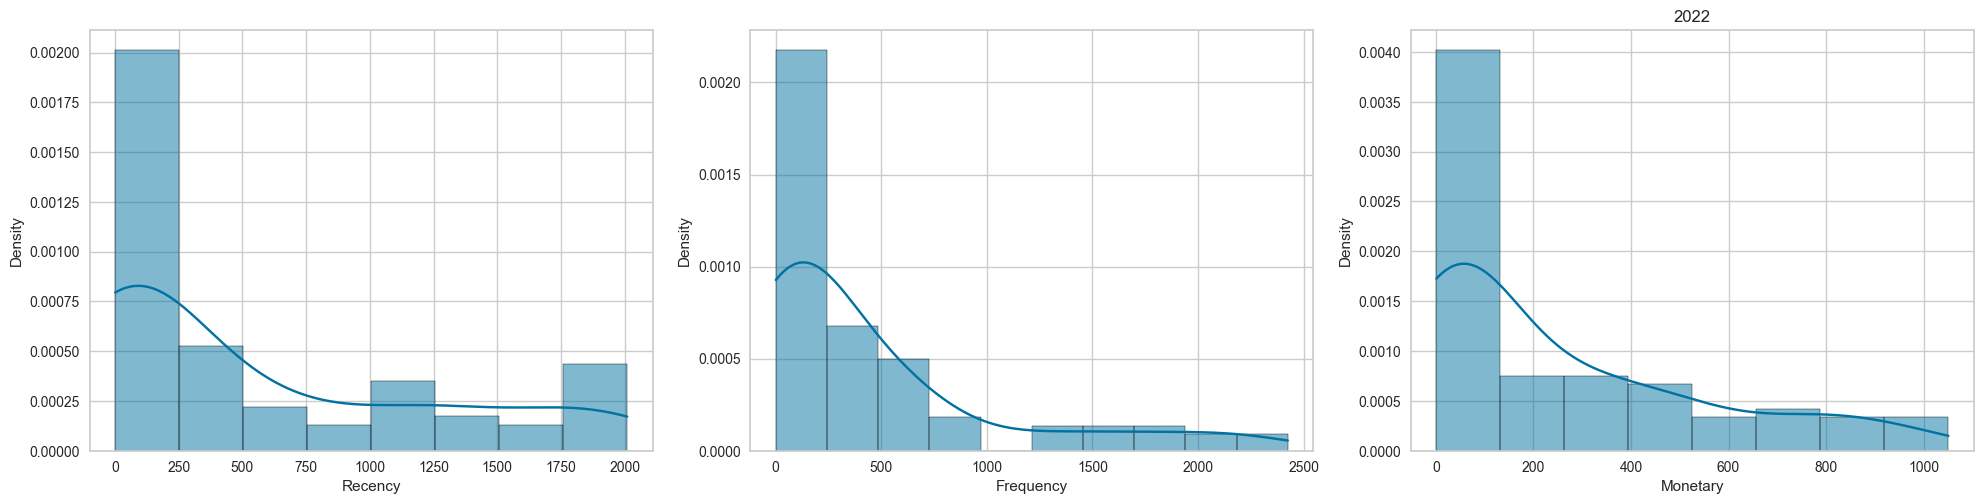

In [189]:
cols = ['Recency', 'Frequency', 'Monetary']

# create the figure and axes
fig, axes = plt.subplots(1, 3, figsize=(20,5))
axes = axes.ravel()  # flattening the array makes indexing easier

for col, ax in zip(cols, axes):
    sns.histplot(data=rfm_df[col], kde=True, stat='density', ax=ax)

fig.tight_layout()
plt.title('2022')
plt.show()

In [92]:
display(rfm_df.describe())

,Recency,Frequency,Monetary
count,46.000000,46.000000,46.000000
mean,38.717391,756.282609,155.413043
std,56.948969,863.694433,146.430503
min,1.000000,1.000000,1.000000
25%,4.000000,53.000000,23.750000
50%,6.500000,411.500000,124.000000
75%,28.000000,1307.000000,284.750000
max,188.000000,2760.000000,476.000000


<AxesSubplot: >

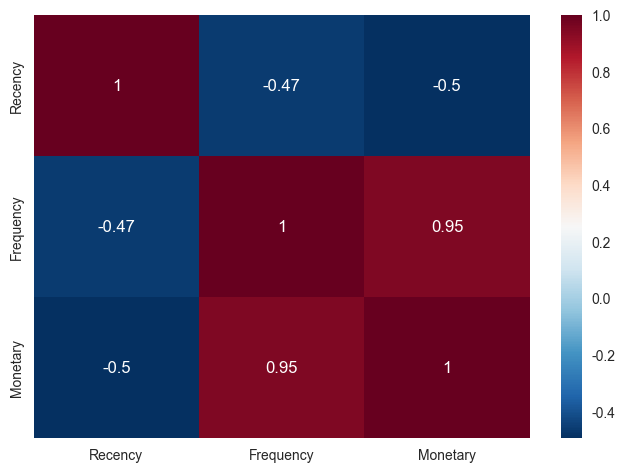

In [93]:
sns.heatmap(rfm_df.iloc[:, 0:3].corr(), annot=True, cmap='RdBu_r')

### rfm_normalized

In [341]:
scaler = MaxAbsScaler()
rfm_normalized = pd.DataFrame(scaler.fit_transform(rfm_df))
rfm_normalized.columns = ['n_Recency', 'n_Frequency', 'n_Monetary']
rfm_normalized.describe()

,n_Recency,n_Frequency,n_Monetary
count,91.000000,91.000000,91.000000
mean,0.279236,0.185612,0.242375
std,0.334433,0.249657,0.276616
min,0.000498,0.000412,0.000951
25%,0.003234,0.014639,0.021884
50%,0.093532,0.086186,0.107517
75%,0.555721,0.243711,0.389629
max,1.000000,1.000000,1.000000


Kmeans 참고
- https://bcho.tistory.com/1203

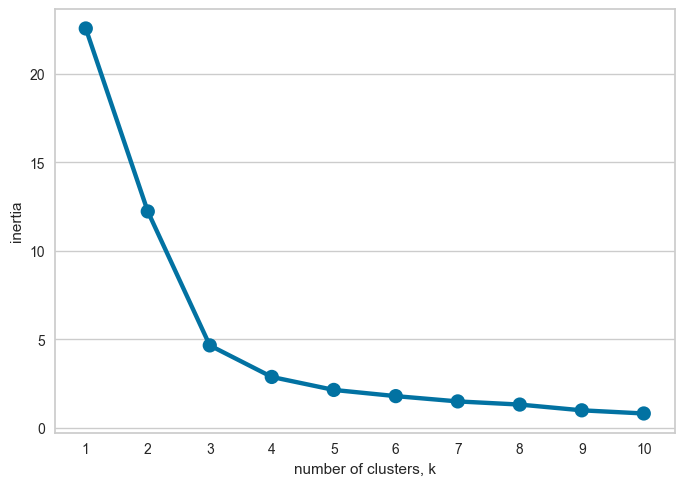

In [342]:
from sklearn.cluster import KMeans
SSE = []
for k in range(0, 10):
    kmeans = KMeans(n_clusters=k+1, random_state=0, n_init="auto").fit(rfm_normalized)
    SSE.append(kmeans.inertia_)

sns.pointplot(x=list(range(1,11)), y=SSE)
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.show()

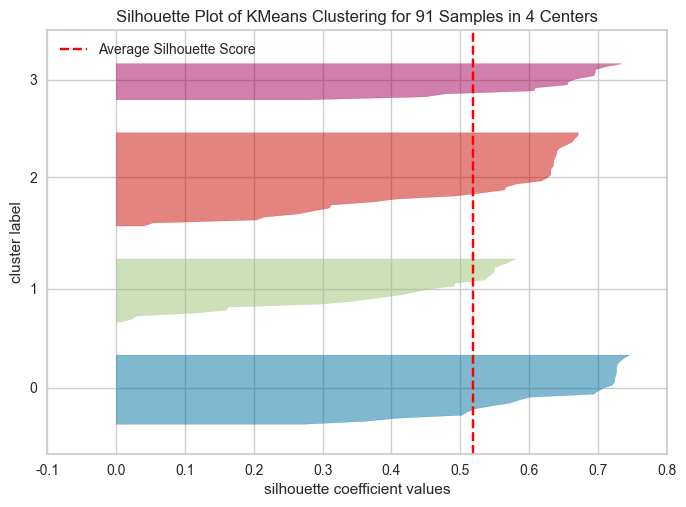

<AxesSubplot: title={'center': 'Silhouette Plot of KMeans Clustering for 91 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [343]:
from yellowbrick.cluster import SilhouetteVisualizer
X = rfm_normalized

model = KMeans(4, random_state=0)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

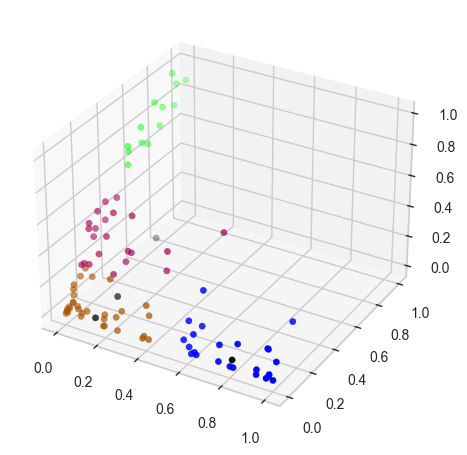

In [344]:
model = KMeans(4, random_state=0).fit(rfm_normalized)
centers=model.cluster_centers_
fig=plt.figure()
ax=fig.add_subplot(111, projection='3d')
ax.scatter(rfm_normalized['n_Recency'], rfm_normalized['n_Frequency'], rfm_normalized['n_Monetary']
           , cmap='brg', c=model.predict(rfm_normalized))
ax.scatter(centers[:,0], centers[:,1], c='black')

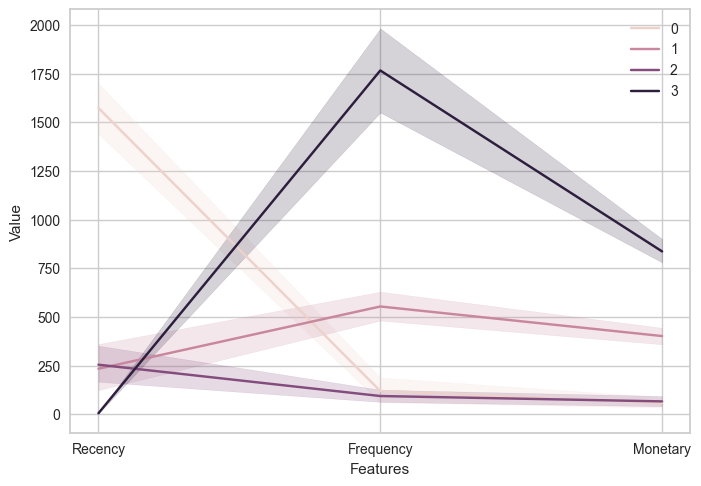

In [345]:
rfm_=pd.DataFrame(scaler.inverse_transform(rfm_normalized))

rfm_.columns = rfm_df.columns
rfm_['cid'] = rfm_df.index
rfm_['Cluster'] = model.labels_

melted_rfm_normalized = pd.melt(rfm_.reset_index()
                                , id_vars=['cid', 'Cluster']
                                , value_vars=['Recency', 'Frequency', 'Monetary']
                                , var_name='Features'
                                , value_name='Value')
sns.lineplot('Features', 'Value', hue='Cluster', data=melted_rfm_normalized)
plt.legend()

### RFM Score

In [346]:
rfm_.groupby('Cluster').agg({
    'Recency':['mean', 'min', 'max']
    , 'Frequency':['mean', 'min', 'max']
    , 'Monetary':['mean', 'min', 'max', 'count']})

Recency                    Frequency                    Monetary  \
                mean     min     max         mean     min     max        mean   
Cluster                                                                         
0        1572.916667  1110.0  2010.0   118.875000     2.0   673.0   57.666667   
1         233.318182     2.0  1107.0   553.227273   255.0   929.0  401.227273   
2         254.093750     4.0   825.0    93.187500     1.0   344.0   65.656250   
3           4.692308     1.0    10.0  1765.692308  1230.0  2425.0  836.076923   

                              
           min     max count  
Cluster                       
0          1.0   301.0    24  
1        239.0   552.0    22  
2          1.0   252.0    32  
3        670.0  1051.0    13

In [347]:
s1 = np.full((1, rfm_df.shape[0]-int(0.75*rfm_df.shape[0])), 4)
s2 = np.full((1, int(0.75*rfm_df.shape[0]) - int(0.5*rfm_df.shape[0])), 3)
s3 = np.full((1, int(0.5*rfm_df.shape[0]) - int(0.25*rfm_df.shape[0])), 2)
s4 = np.full((1, int(0.25*rfm_df.shape[0]) - int(0.0*rfm_df.shape[0])), 1)

score = np.hstack((s1,s2,s3,s4,)).flatten()

rfm_df = rfm_df.sort_values(by='Recency', ascending=False)
rfm_df['r_score'] = score

for i,j in zip(('Frequency', 'Monetary'), ('f_score', 'm_score')):
    rfm_df = rfm_df.sort_values(by=i)
    rfm_df[j] = score
rfm_df

,Recency,Frequency,Monetary,r_score,f_score,m_score
cid,,,,,,
이대호-71564,522,1.0,1,3,4,4
이성열-73136,1638,2.0,1,4,4,4
나주환-73209,1946,2.0,1,4,4,4
김재환-78224,381,4.0,1,3,4,4
윤요섭-78892,2010,2.0,2,4,4,4
...,...,...,...,...,...,...
이재원-76812,7,1933.0,876,2,1,1
유강남-61102,1,2425.0,936,1,1,1
양의지-76232,5,1780.0,947,1,1,1


<AxesSubplot: >

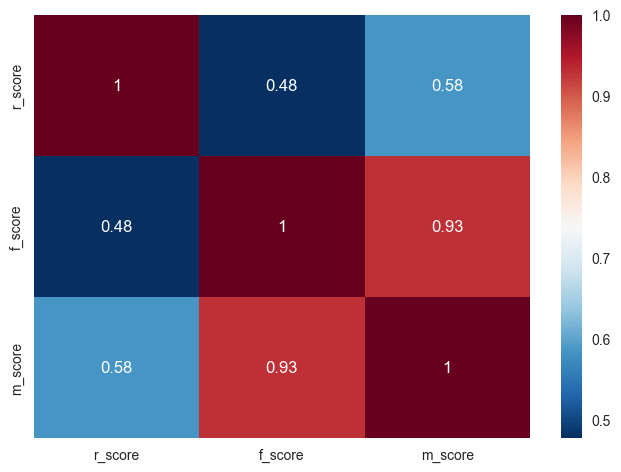

In [348]:
sns.heatmap(rfm_df.iloc[:, 3:6].corr(), annot=True, cmap='RdBu_r')

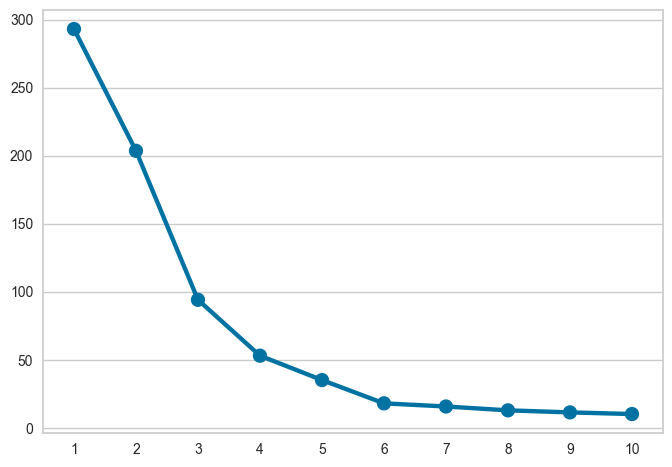

In [153]:
from sklearn.cluster import KMeans
SSE = []
for k in range(0, 10):
    kmeans = KMeans(n_clusters=k+1, random_state=0, n_init="auto").fit(rfm_df.iloc[:, 3:])
    SSE.append(kmeans.inertia_)

sns.pointplot(x=list(range(1,11)), y=SSE)
plt.show()

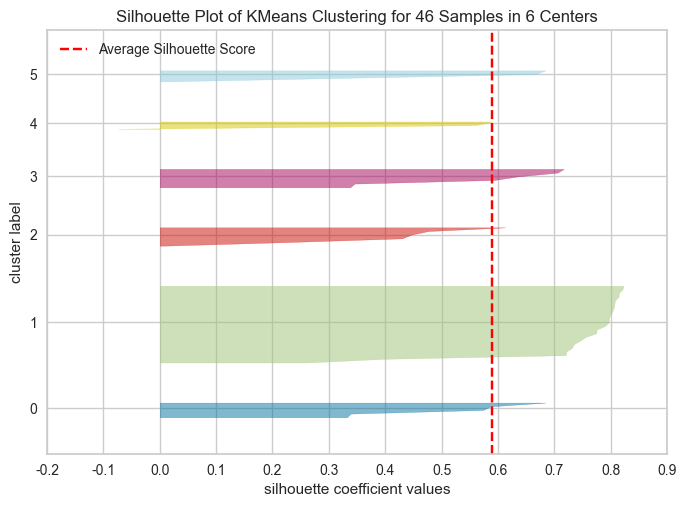

<AxesSubplot: title={'center': 'Silhouette Plot of KMeans Clustering for 46 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [154]:
from yellowbrick.cluster import SilhouetteVisualizer
X = rfm_df

model = KMeans(6, random_state=0)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

visualizer.fit(X)
visualizer.show()     

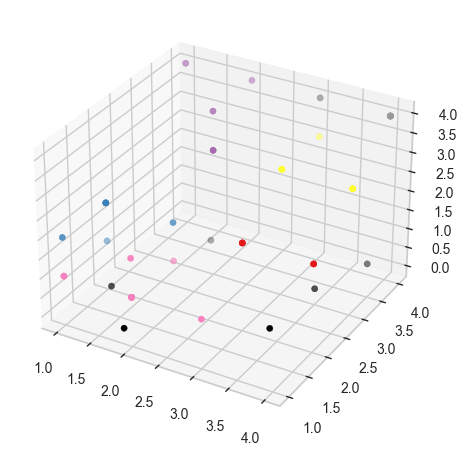

In [169]:
model = KMeans(6, random_state=0).fit(rfm_df[['r_score', 'f_score', 'm_score']])
centers=model.cluster_centers_
fig=plt.figure()
ax=fig.add_subplot(111, projection='3d')
ax.scatter(rfm_df['r_score'], rfm_df['f_score'], rfm_df['m_score']
           , cmap='Set1', c=model.predict(rfm_df[['r_score', 'f_score', 'm_score']]))
ax.scatter(centers[:,0], centers[:,1], c='black')

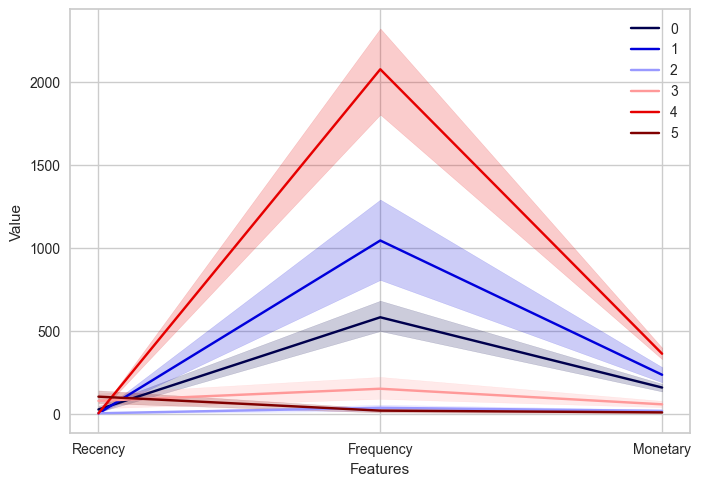

In [171]:
rfm_df['Cluster'] = model.labels_

melted_rfm = pd.melt(rfm_df.reset_index()
                                , id_vars=['cid', 'Cluster']
                                , value_vars=['Recency', 'Frequency', 'Monetary']
                                , var_name='Features'
                                , value_name='Value')
sns.lineplot('Features', 'Value', hue='Cluster', data=melted_rfm, palette='seismic')
plt.legend()

In [172]:
rfm_df.groupby('Cluster').agg({
    'Recency':['mean', 'min', 'max', 'std', 'var']
    , 'Frequency':['mean', 'min', 'max', 'std', 'var']
    , 'Monetary':['mean', 'min', 'max', 'count', 'std', 'var']})

Recency                                     Frequency              \
               mean min  max        std          var         mean   min   max   
Cluster                                                                         
0         27.200000  10   70  24.893774   619.700000   582.000000   448   785   
1          3.714286   2    4   0.755929     0.571429  1044.000000   668  1561   
2          4.333333   4    5   0.516398     0.266667    37.166667     6    66   
3         79.000000  12  178  70.350906  4949.250000   152.000000    51   375   
4          4.272727   1    7   1.902152     3.618182  2074.363636  1120  2760   
5        104.375000  15  188  60.182906  3621.982143    20.250000     1    53   

                                      Monetary                             \
                std            var        mean  min  max count        std   
Cluster                                                                     
0        126.639251   16037.500000  159.200000  125  187     5  29.055120   
1        328.374786  107830.000000  236.000000  150  339     7  69.267597   
2         26.528601     703.766667   18.500000    4   32     6  11.674759   
3        107.839000   11629.250000   58.222222   29  123     9  30.873847   
4        468.336049  219338.654545  362.636364  276  476    11  62.171171   
5         18.140326     329.071429    9.625000    1   21     8   7.110103   

                      
                 var  
Cluster               
0         844.200000  
1        4798.000000  
2         136.300000  
3         953.194444  
4        3865.254545  
5          50.553571